In [1]:
import pandas as pd
import mne
import os
import numpy as np
from mne.time_frequency import tfr_morlet
import ast

In [2]:
ROOT_preproc='/data/backed_up/shared/AlphaStudy_data/placeholders/preproc_EEG_matchingBrad/'
list_subs=os.listdir(ROOT_preproc)
preproc_cue_eps={}
preproc_probe_eps={}
for s in list_subs:
    cue=mne.read_epochs(ROOT_preproc+s+'/'+'cue-epo.fif')
    probe=mne.read_epochs(ROOT_preproc+s+'/'+'probe events-epo.fif')
    preproc_cue_eps[s]=cue
    preproc_probe_eps[s]=probe

Reading /data/backed_up/shared/AlphaStudy_data/placeholders/preproc_EEG_matchingBrad/224/cue-epo.fif ...
    Found the data of interest:
        t =   -1300.78 ...    1000.00 ms
        0 CTF compensation matrices available
660 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 15 columns
0 projection items activated
Reading /data/backed_up/shared/AlphaStudy_data/placeholders/preproc_EEG_matchingBrad/224/probe events-epo.fif ...
    Found the data of interest:
        t =       0.00 ...    5400.39 ms
        0 CTF compensation matrices available
660 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 15 columns
0 projection items activated
Reading /data/backed_up/shared/AlphaStudy_data/placeholders/preproc_EEG_matchingBrad/214/cue-epo.fif ...
    Found the data of interest:
        t =   -1300.78 ...    1000.00 ms
        0 CTF compensation matrices available
592 matching events found
Applying baseline correction (mode:

## Isolating the trials with only the right-most and left-most cues, ie those that appeared at three oclock and nine oclock

In [3]:
right_stim=['5']#['1','3','5']
center_stim=['6','12']
left_stim=['7']#['7','9','11']
# We have to loop through each subject, each condition, 
# and find every trial that is *not* in the L, R, or center,
# and drop those tirals from 3 copies of the original epochs to get three
# copies that are only L, R, or Center trials

conditions=['tarShortCue_trig','disShortCue_trig',
           'tarLongCue_trig','disLongCue_trig']#,'neutShortCue_trig','neutLongCue_trig']
preprocCues_LeftNINE={}
preprocCues_RightTHREE={}
preprocCues_CenterSIXTWELVE={}

for sub in preproc_cue_eps.keys():
    
    preprocCues_LeftNINE[sub]={}
    preprocCues_RightTHREE[sub]={}
    preprocCues_CenterSIXTWELVE[sub]={}
    
    # load cue_epochs for this sub
    cue_eps=preproc_cue_eps[sub]
    
    # loop thru conditions
    for cond in conditions:
        epsForThisCond=cue_eps[cond]
                    
        # set up empty lists to be populated with trials that are NOT L/R/center
        not_right=[]
        not_left=[]
        not_center=[]
        
        # will populate w bools where True== drop this trial
        
        # loop thru each trial, and check out the metadata
        for trial_n in range(len(epsForThisCond)):
            this_trial=epsForThisCond[trial_n]
            
            assert this_trial.metadata['trial_type'].iloc[0] in cond            
            # grab out the behav data of this trial
            this_trial_StimLoc=this_trial.metadata['tar,dis stim_loc'].iloc[0]
            this_trial_StimLoc=ast.literal_eval(this_trial_StimLoc) # turn it into a literal tuple
            
            # identify the condition of interest and pull out that stim loc
            if 'tar' in cond:
                thisClockPos=this_trial_StimLoc[0] 
                # if its the target that was the color singleton, we care about which
                                        # hemisphere that was in
            elif 'dis' in cond:
                thisClockPos=this_trial_StimLoc[1]
            
            # if the the clock pos is on the right side of the screen, 
                # then we want to document as not-not right, not left, and not center
            if thisClockPos in right_stim:
                not_right.append(False)
                not_left.append(True)
                not_center.append(True)
            elif thisClockPos in left_stim:
                not_right.append(True)
                not_left.append(False)
                not_center.append(True)
            elif thisClockPos in center_stim:
                not_right.append(True)
                not_left.append(True)
                not_center.append(False)
            else: # if this cue location is not six,twelve,three,or nine
                not_right.append(True)
                not_left.append(True)
                not_center.append(True)
                
        
        #print(len(not_right),len(not_left),len(not_center),len(epsForThisCond))
        assert len(not_right) == len(not_left) == len(not_center) == len(epsForThisCond)
        
        # make three copies of the original epochs for this condition
        all_Rights=epsForThisCond.copy()
        all_Lefts=epsForThisCond.copy()
        all_Centers=epsForThisCond.copy()
        
        # then drop all of the epochs that are "True" in not being on the side of the screen we want
        all_Rights.drop(indices=np.asarray(not_right),reason='Dropping all left and centers')
        all_Lefts.drop(indices=np.asarray(not_left),reason='Dropping all right and centers')
        all_Centers.drop(indices=np.asarray(not_center),reason='Dropping all left and rights')
        
        # asserting that the len of the original eps object == 
        # [3x len of the original epochs object] minus [the sum of all dropped epochs]
        # Did this to make sure no "False" is "True" in any other list
        #assert ((len(epsForThisCond)*3)-(np.sum(not_right)+np.sum(not_left)+np.sum(not_center)))==len(epsForThisCond)
        
        # now put it into a dict
        preprocCues_LeftNINE[sub][cond]=all_Lefts
        preprocCues_RightTHREE[sub][cond]=all_Rights
        preprocCues_CenterSIXTWELVE[sub][cond]=all_Centers
        print(len(all_Lefts))
        print(len(all_Rights))
        print(len(all_Centers))

Dropped 95 epochs
Dropped 92 epochs
Dropped 90 epochs
18
15
20
Dropped 94 epochs
Dropped 98 epochs
Dropped 78 epochs
12
16
32
Dropped 99 epochs
Dropped 100 epochs
Dropped 80 epochs
10
11
30
Dropped 101 epochs
Dropped 84 epochs
Dropped 84 epochs
26
9
26
Dropped 80 epochs
Dropped 91 epochs
Dropped 70 epochs
8
19
29
Dropped 90 epochs
Dropped 89 epochs
Dropped 75 epochs
11
10
25
Dropped 83 epochs
Dropped 79 epochs
Dropped 73 epochs
19
15
25
Dropped 84 epochs
Dropped 81 epochs
Dropped 81 epochs
18
15
18
Dropped 83 epochs
Dropped 85 epochs
Dropped 77 epochs
13
15
21
Dropped 76 epochs
Dropped 85 epochs
Dropped 76 epochs
13
22
22
Dropped 89 epochs
Dropped 88 epochs
Dropped 73 epochs
11
10
26
Dropped 88 epochs
Dropped 82 epochs
Dropped 70 epochs
15
9
27
Dropped 87 epochs
Dropped 90 epochs
Dropped 74 epochs
10
13
26
Dropped 88 epochs
Dropped 86 epochs
Dropped 73 epochs
14
12
27
Dropped 87 epochs
Dropped 88 epochs
Dropped 79 epochs
12
13
21
Dropped 82 epochs
Dropped 87 epochs
Dropped 77 epochs
13

In [4]:
freqs=np.arange(.5,38.,2.)
n_cycles = freqs / 2.
leftPost_elecs=['CP5','CP3','P7','P5','P3','PO3','PO7']
rightPost_elecs=['CP4','CP6','P4','P6','P8','PO4','PO8']
all_conds=['tarShortCue_trig','disShortCue_trig',
           'tarLongCue_trig','disLongCue_trig'] # ,'neutLongCue_trig,'neutShortCue_trig',
all_subs_Lefts={}
all_subs_Rights={}
all_subs_Centers={}

for lateralizedSubDict in [preprocCues_LeftNINE, preprocCues_RightTHREE, preprocCues_CenterSIXTWELVE]:
    
    for cond in all_conds: 
        # loading an example subject to steal the python object's structure
        # and overwrite the subject data with a group average
        skeleton_obj=mne.time_frequency.tfr_morlet(lateralizedSubDict['228'][cond],freqs=freqs,n_cycles=n_cycles,
                                                   average=True,use_fft=True,return_itc=False, decim=2, n_jobs=1)
        thisCond_allSubsDat=[]
        for s in list_subs:
            #print('\n\n\n')
            thisSub=lateralizedSubDict[s][cond]
            print('extracting sub {0}, cond {1}'.format(s,cond))
            subDat=mne.time_frequency.tfr_morlet(thisSub,freqs=freqs,n_cycles=n_cycles,average=True,
                                                     use_fft=True,return_itc=False, decim=2, n_jobs=1)
            thisCond_allSubsDat.append(subDat.data)
            
        # compiling all subjects' data for this condition, in this hemisphere
        all_subs_thisCond=np.stack(thisCond_allSubsDat)
        # and averaging across the "subject" dimension
        assert all_subs_thisCond.shape[0] == len(list_subs)
        all_subs_thisCond=all_subs_thisCond.mean(axis=0)
        # then feeding that into the skeleton MNE averageTFR object
        skeleton_obj.data=all_subs_thisCond

        skeleton_obj.apply_baseline(mode='zscore', baseline=(-1.300, -0.5))
        
        if lateralizedSubDict==preprocCues_LeftNINE:
            all_subs_Lefts[cond]=skeleton_obj
            print('Finished with left hemis for this cond')
        elif lateralizedSubDict==preprocCues_RightTHREE:
            all_subs_Rights[cond]=skeleton_obj
            print('Finished with right hemis for this cond')
        elif lateralizedSubDict==preprocCues_CenterSIXTWELVE:
            all_subs_Centers[cond]=skeleton_obj
            print('Finished w centers for this cond')
        

/home/dcellier/condaenvs/p3env/lib/python3.7/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


extracting sub 224, cond tarShortCue_trig
extracting sub 214, cond tarShortCue_trig
extracting sub 211, cond tarShortCue_trig
extracting sub 206, cond tarShortCue_trig
extracting sub 225, cond tarShortCue_trig
extracting sub 226, cond tarShortCue_trig
extracting sub 233, cond tarShortCue_trig
extracting sub 223, cond tarShortCue_trig
extracting sub 197, cond tarShortCue_trig
extracting sub 228, cond tarShortCue_trig
Applying baseline correction (mode: zscore)
Finished with left hemis for this cond
extracting sub 224, cond disShortCue_trig
extracting sub 214, cond disShortCue_trig
extracting sub 211, cond disShortCue_trig
extracting sub 206, cond disShortCue_trig
extracting sub 225, cond disShortCue_trig
extracting sub 226, cond disShortCue_trig
extracting sub 233, cond disShortCue_trig
extracting sub 223, cond disShortCue_trig
extracting sub 197, cond disShortCue_trig
extracting sub 228, cond disShortCue_trig
Applying baseline correction (mode: zscore)
Finished with left hemis for this

## target long SOA, Right (three oclock) Minus Center 



plotting RIGHT hemisphere MINUS CENTER for tarLongCue_trig

No baseline correction applied


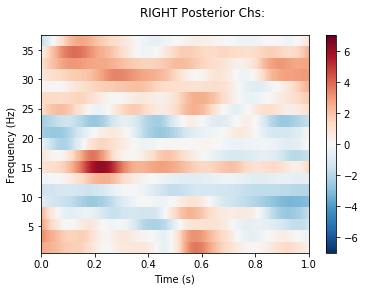

No baseline correction applied


/home/dcellier/condaenvs/p3env/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


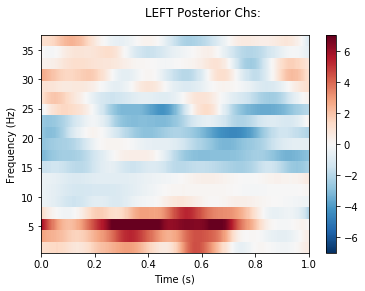

Plotting theta 0-200msec
No baseline correction applied


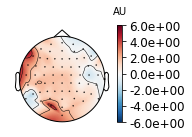

Plotting theta 200-400msec
No baseline correction applied


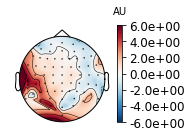

Plotting theta 400-800msec
No baseline correction applied


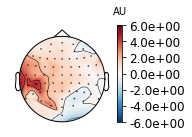

Plotting theta 800-1000msec
No baseline correction applied


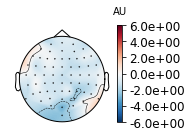

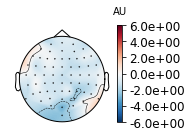

In [9]:
cond='tarLongCue_trig'
## Contrasting with centrally presented:
lat=all_subs_Rights[cond]
center=all_subs_Centers[cond]
latMinusCenter=lat-center
print('\n\nplotting RIGHT hemisphere MINUS CENTER for %s\n' %cond)
latMinusCenter.plot(vmin=-7,vmax=7,tmin=0,tmax=1,picks=rightPost_elecs,title='RIGHT Posterior Chs:').show()
latMinusCenter.plot(vmin=-7,vmax=7,tmin=0,tmax=1,picks=leftPost_elecs,title='LEFT Posterior Chs:').show()

print('Plotting theta 0-200msec')
latMinusCenter.plot_topomap(fmin=4,fmax=8,tmin=0,tmax=0.2,vmin=-6,vmax=6)
print('Plotting theta 200-400msec')
latMinusCenter.plot_topomap(fmin=4,fmax=8,tmin=0.2,tmax=0.4,vmin=-6,vmax=6)
print('Plotting theta 400-800msec')
latMinusCenter.plot_topomap(fmin=4,fmax=8,tmin=0.4,tmax=0.8,vmin=-6,vmax=6)
print('Plotting theta 800-1000msec')
latMinusCenter.plot_topomap(fmin=4,fmax=8,tmin=0.8,tmax=1,vmin=-6,vmax=6)

## target long SOA, Left (nine oclock) Minus Center 



plotting LEFT hemisphere MINUS CENTER for tarLongCue_trig

No baseline correction applied


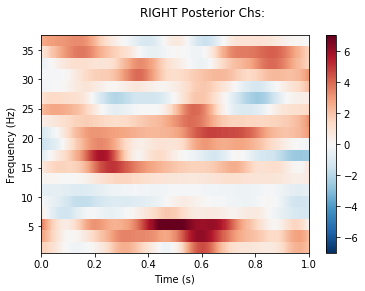

No baseline correction applied


/home/dcellier/condaenvs/p3env/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


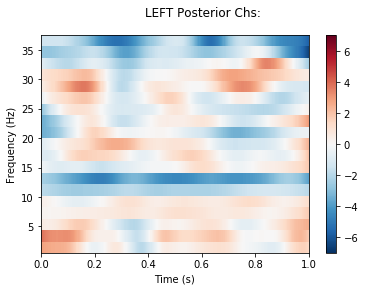

Plotting THETA 0-200msec
No baseline correction applied


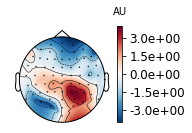

Plotting THETA 200-400msec
No baseline correction applied


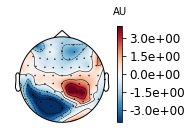

Plotting THETA 400-800msec
No baseline correction applied


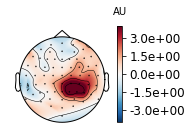

Plotting THETA 800-1000msec
No baseline correction applied


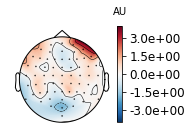

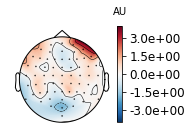

In [6]:
cond='tarLongCue_trig'
## Contrasting with centrally presented:
lat=all_subs_Lefts[cond]
center=all_subs_Centers[cond]
latMinusCenter=lat-center
print('\n\nplotting LEFT hemisphere MINUS CENTER for %s\n' %cond)
latMinusCenter.plot(vmin=-7,vmax=7,tmin=0,tmax=1,picks=rightPost_elecs,title='RIGHT Posterior Chs:').show()
latMinusCenter.plot(vmin=-7,vmax=7,tmin=0,tmax=1,picks=leftPost_elecs,title='LEFT Posterior Chs:').show()

print('Plotting THETA 0-200msec')
latMinusCenter.plot_topomap(fmin=4,fmax=8,tmin=0,tmax=0.2,vmin=-4,vmax=4)
print('Plotting THETA 200-400msec')
latMinusCenter.plot_topomap(fmin=4,fmax=8,tmin=0.2,tmax=0.4,vmin=-4,vmax=4)
print('Plotting THETA 400-800msec')
latMinusCenter.plot_topomap(fmin=4,fmax=8,tmin=0.4,tmax=0.8,vmin=-4,vmax=4)
print('Plotting THETA 800-1000msec')
latMinusCenter.plot_topomap(fmin=4,fmax=8,tmin=0.8,tmax=1,vmin=-4,vmax=4)

## distractor long SOA, Right (three oclock) Minus Center 



plotting RIGHT hemisphere MINUS CENTER for disLongCue_trig

No baseline correction applied


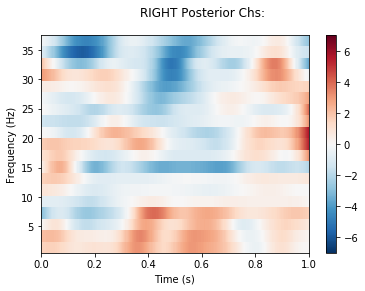

No baseline correction applied


/home/dcellier/condaenvs/p3env/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


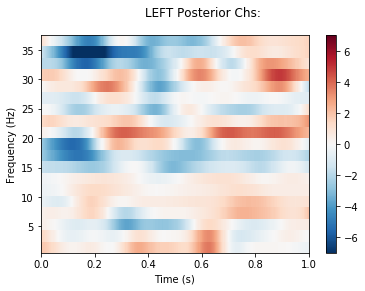

No baseline correction applied


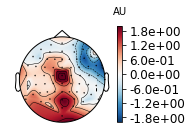

No baseline correction applied


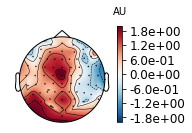

No baseline correction applied


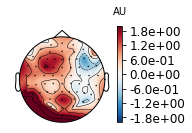

No baseline correction applied


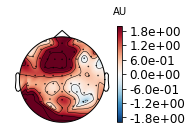

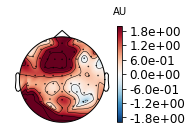

In [7]:
cond='disLongCue_trig'
## Contrasting with centrally presented:
lat=all_subs_Rights[cond]
center=all_subs_Centers[cond]
latMinusCenter=lat-center
print('\n\nplotting RIGHT hemisphere MINUS CENTER for %s\n' %cond)
latMinusCenter.plot(vmin=-7,vmax=7,tmin=0,tmax=1,picks=rightPost_elecs,title='RIGHT Posterior Chs:').show()
latMinusCenter.plot(vmin=-7,vmax=7,tmin=0,tmax=1,picks=leftPost_elecs,title='LEFT Posterior Chs:').show()

latMinusCenter.plot_topomap(fmin=8,fmax=14,tmin=0,tmax=0.2,vmin=-2,vmax=2)
latMinusCenter.plot_topomap(fmin=8,fmax=14,tmin=0.2,tmax=0.4,vmin=-2,vmax=2)
latMinusCenter.plot_topomap(fmin=8,fmax=14,tmin=0.4,tmax=0.8,vmin=-2,vmax=2)
latMinusCenter.plot_topomap(fmin=8,fmax=14,tmin=0.8,tmax=1,vmin=-2,vmax=2)

## distractor long SOA, Left (nine oclock) Minus Center 



plotting LEFT hemisphere MINUS CENTER for disLongCue_trig

No baseline correction applied


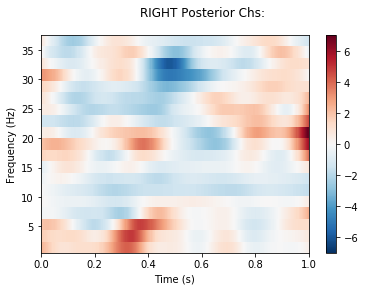

No baseline correction applied


/home/dcellier/condaenvs/p3env/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


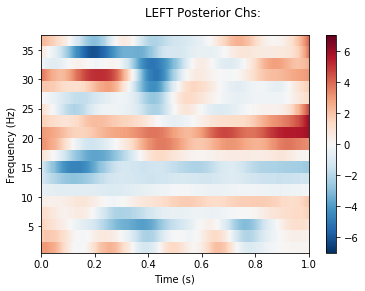

No baseline correction applied


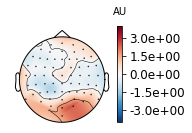

No baseline correction applied


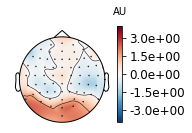

No baseline correction applied


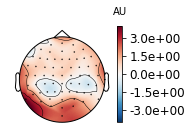

No baseline correction applied


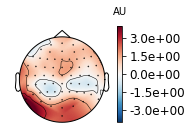

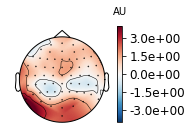

In [8]:
cond='disLongCue_trig'
## Contrasting with centrally presented:
lat=all_subs_Lefts[cond]
center=all_subs_Centers[cond]
latMinusCenter=lat-center
print('\n\nplotting LEFT hemisphere MINUS CENTER for %s\n' %cond)
latMinusCenter.plot(vmin=-7,vmax=7,tmin=0,tmax=1,picks=rightPost_elecs,title='RIGHT Posterior Chs:').show()
latMinusCenter.plot(vmin=-7,vmax=7,tmin=0,tmax=1,picks=leftPost_elecs,title='LEFT Posterior Chs:').show()

latMinusCenter.plot_topomap(fmin=8,fmax=14,tmin=0,tmax=0.2,vmin=-4,vmax=4)
latMinusCenter.plot_topomap(fmin=8,fmax=14,tmin=0.2,tmax=0.4,vmin=-4,vmax=4)
latMinusCenter.plot_topomap(fmin=8,fmax=14,tmin=0.4,tmax=0.8,vmin=-4,vmax=4)
latMinusCenter.plot_topomap(fmin=8,fmax=14,tmin=0.8,tmax=1,vmin=-4,vmax=4)